In [1]:
# global variables

SAVE_ELEMENTS = False

#paths
BPI_PATH = 'BPI Challenge 2017.xes'
ACTIVITIES_PATH = 'activities.xml'

# log processing
MIN_SPEAKING_TIME = 60
SPEAK_THRESHOLD = 600
DAY_DIFFERENCE = 20

# verfification
VERIFYTA_PATH = "/home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bin/verifyta"
INTERMEDIATE_MODEL_NAME = "bpi2017subgraph.xml"
UPPAAL_MODEL_FOLDER = "/home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/"

# transition system
SEQUENCE_HISTORY = 3

In [2]:
import numpy as np
import random
import pandas as pd
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.visualization.dfg import visualizer as dfg_visualization
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph
import matplotlib.pyplot as plt

import copy
from collections import Counter

import pygraphviz as pgv
import json

import pm4py

from collections import Counter
import subprocess

In [3]:
# Load the log
from pm4py.objects.log.importer.xes import importer as xes_importer
log_application = xes_importer.apply(BPI_PATH)

parsing log, completed traces ::   0%|          | 0/31509 [00:00<?, ?it/s]

# Investigate implications in the log
Certain events always surround other events or are always followed by other events.
We discover some connections to reduce the size of later modells.

In [4]:
# A_complete is always preceeded by "W_call after offers"
for trace in log_application:
    for pos_index in range(len(trace)):
        pos = trace[pos_index]
        if "A_Complete" in pos["concept:name"]:
            if "W_Call after offers" not in trace[pos_index-1]["concept:name"]:
                for e in trace[pos_index-5:pos_index+5]:
                    print(e["concept:name"])
                print("not followed")
                assert(False)

In [5]:
# "W_call after offers" has always "A_complete"
for trace in log_application:
    for pos_index in range(len(trace)):
        pos = trace[pos_index]
        if "W_call after offers" in pos["concept:name"]:
            index_inner = pos_index+1
            while trace[index_inner]["concept:name"] == "W_call after offers":
                index_inner += 1
            if "A_complete" not in trace[index_inner]["concept:name"]:
                for e in trace[index_inner-5:index_inner+5]:
                    print(e["concept:name"])
                print("not followed")
                assert(False)

In [6]:
# A_Incomplete is always surrounded by "W_Call incomplete files"
for trace in log_application:
    for pos_index in range(len(trace)):
        pos = trace[pos_index]
        if "A_Incomplete" in pos["concept:name"]:
            if "W_Call incomplete files" not in trace[pos_index-1]["concept:name"] and "W_Call incomplete files" not in trace[pos_index+1]["concept:name"]:
                for e in trace[pos_index-5:pos_index+5]:
                    print(e["concept:name"])
                print("not followed")
                assert(False)

In [7]:
#Create offer is always followed by "Created"
for trace in log_application:
    for pos_index in range(len(trace)):
        pos = trace[pos_index]
        if "Create Offer" in pos["concept:name"]:
            if "Created" not in trace[pos_index+1]["concept:name"]:
                print("not followed")

In [8]:
# number of calls
for trace in log_application:
    for pos_index in range(len(trace)):
        pos = trace[pos_index]
        if "Create Offer" in pos["concept:name"]:
            if "Created" not in trace[pos_index+1]["concept:name"]:
                print("not followed")

In [9]:
def contains(trace, element):
    for event in trace:
        if event['concept:name']==element:
            return True

# Preprocessing of the log
Several operations are performed:
- The log is split into two parts at the concept drift
- Call events ('W_Call incomplete files' and 'W_Call after offers') are accumulated and discretized by time. 
- - With a runtime of 60 - 600 sec. is the event considered as "SHORT"
- - between 10min and 4h as "LONG"
- - exceeding 4h as "SUPER LONG"
- Other workflow events are ignored
- Cancellation events after A_Pending are ignored
- 'O_Create Offer' is tagged (enumerted to consider how many offers were created)
- s_0 and terminal states are appended

In [10]:
log = copy.deepcopy(log_application)
log_before = pm4py.filter_time_range(log, "2011-03-09 00:00:00", "2016-06-30 23:59:59", mode='traces_contained')
log_after = pm4py.filter_time_range(log, "2016-08-01 00:00:00", "2018-03-09 00:00:00", mode='traces_contained')

In [11]:
# The log is filtered based on variations.
def filter_log(log):
    perc = 2/len(log)
    return pm4py.filter_variants_by_coverage_percentage(log, perc)

filtered_log_before = filter_log(log_before)
filtered_log_after = filter_log(log_after)

In [12]:
def construct_log(log):
    terminal_states = ['A_Cancelled COMPANY', 'A_Cancelled CUSTOMER', 'A_Pending', 'TIMEOUT']#, 'A_Denied']
    to_merge = ['W_Call incomplete files', 'W_Call after offers', 'W_Complete application', 'W_Validate application']
    log_activities = []
    for trace in log:
        current_trace = [trace[0]]
        for i in range(1,len(trace)):
            pos = trace[i]
            if "W_Call" in trace[i]['concept:name']:
                # search for closing event
                if pos['lifecycle:transition'] in ["start", "resume"]:
                    for inner_index in range(i+1, len(trace)):
                        inner_pos = trace[inner_index]
                        if pos['concept:name'] == inner_pos['concept:name']:
                            if inner_pos['lifecycle:transition'] in ["suspend", "complete"]:                 
                                duration = (inner_pos['time:timestamp']-pos['time:timestamp']).total_seconds()
                                if duration > MIN_SPEAKING_TIME:
                                    if pos['concept:name'] in current_trace[-1]["concept:name"]:
                                        current_trace[-1]["duration"] += duration
                                    else:
                                        current_trace.append(pos)
                                        current_trace[-1]['duration'] = duration
                                    if current_trace[-1]["duration"] < SPEAK_THRESHOLD:
                                        current_trace[-1]['concept:name'] = pos['concept:name']+" SHORT"
                                    elif current_trace[-1]["duration"] < 14400:
                                        current_trace[-1]['concept:name'] = pos['concept:name']+" LONG"
                                    else:
                                        current_trace[-1]['concept:name'] = pos['concept:name']+" SUPER LONG"
                            break
            if "W_" in trace[i]['concept:name']:
                continue # skip other workflow events
            if trace[i]['concept:name'] in ["A_Created", "A_Complete", "A_Incomplete"]:
                continue # skip trivial elements
            if trace[i]['concept:name'] == "A_Cancelled": #differentiate between user_abort and timeout
                current_trace.append(pos)
                if (trace[i]['time:timestamp']-trace[i-1]['time:timestamp']).days >= DAY_DIFFERENCE:
                    current_trace[-1]['concept:name'] = "TIMEOUT"
                else:
                    current_trace[-1]['concept:name'] += " CUSTOMER"
                continue
            if "O_Created" == trace[i]['concept:name']:
                continue # merge create and created
            if trace[i]['concept:name'] in terminal_states:
                current_trace.append(pos)
            else:
                if trace[i]['concept:name'] in to_merge and trace[i]['concept:name'] == trace[i-1]['concept:name']:
                    continue
                else:
                    current_trace.append(pos)
        if "A_Pending" in [pos['concept:name'] for pos in current_trace]:
            if "O_Cancelled" in [pos['concept:name'] for pos in current_trace]:
                for pos1 in current_trace:
                    if 'O_Cancelled' in pos1['concept:name']:
                        current_trace.remove(pos1)
        intersection = [i for i in trace if i['concept:name'] in terminal_states]
        for state in terminal_states:
            indices = [i for i, x in enumerate(current_trace) if x['concept:name'] == state]
            if indices:
                current_trace = current_trace[:indices[0]+1]
        if intersection:
            log_activities.append(current_trace)
    
    return log_activities

filtered_log_before = construct_log(filtered_log_before)
filtered_log_after = construct_log(filtered_log_after)

In [13]:
# process log to iterate created offers and differentiate between positive and negative traces
MAX_INDEX = 100
def process_log(log):
    
    for trace in log:
        #trace.insert(0,{'concept:name': "start"})
        isPositive = False
        if contains(trace, 'A_Pending'):
            isPositive = True
        trace.insert(0,{'concept:name': "start"})
        if isPositive:
            trace.append({'concept:name': "positive"})
        else:
            trace.append({'concept:name': "negative"})
    
    to_extend = ["O_Create Offer"]
    for name in to_extend:
        element = 0
        for trace in log:
            indices = [i for i, x in enumerate(trace) if x['concept:name'] == name]
            for i in indices:
                count_indices = [j for j in indices if j < i]
                index = MAX_INDEX if len(count_indices) > MAX_INDEX else len(count_indices)
                trace[i]['concept:name'] += " "+str(index)

process_log(filtered_log_before)
process_log(filtered_log_after)

In [14]:
# distribuion over positive and negative traces in log
def plot_negative_positive(log):
    outcome = ["positive" if "positive" in [i['concept:name'] for i in trace] else "negative" for trace in log]
    print(Counter(outcome))
plot_negative_positive(filtered_log_before)
plot_negative_positive(filtered_log_after)

Counter({'negative': 2907, 'positive': 2608})
Counter({'negative': 3699, 'positive': 3290})


# Building the transition system
The processes log is used to generate a transition system.
The transition system is extended with actors and then with weights, resulting in a user journey game.

In [15]:
# several abstractions are supported: Sequence (hist) and multiset (ms)
# transforms log into user-journey log
def ms(trace):
    multiset = {}
    for pos in trace:
        if pos['concept:name'] not in multiset:
            multiset[pos['concept:name']] = 1
        else:
            multiset[pos['concept:name']] += 1
    return json.dumps(multiset, sort_keys=True).encode() # use json encodings for multisets

def hist(trace): 
    hist = str(trace[0]['concept:name'])
    for pos in trace[1:]:
        hist += " - " + str(pos['concept:name']) # construct history
    return hist

def transition_system(log, history = 1, actors = {}):
    edges = []
    edge_counter = {}
    controll = {}
    action = {}
    edge_mapping = {}
    for trace_index in range(len(log)):
        trace = log[trace_index]
        s = "start"
        assert(trace[0]['concept:name']=="start")
        for pos_index in range(1,len(trace)):
            pos = trace[pos_index]
            activity = pos['concept:name']
            controllable = True
            for key in actors:
                if key in activity:
                    controllable = actors[key]=='company'
            #t = ms(trace[max(0,pos_index-history+1):pos_index+1])
            t = hist(trace[max(0,pos_index-history+1):pos_index+1])
            e = (s,t)
            controll[e] = controllable
            action[e] = activity
            if e not in edges:
                edges.append(e)
                edge_counter[e] = 1
                edge_mapping[e] = [trace_index]
            else:
                edge_counter[e] = edge_counter[e]+1
                edge_mapping[e].append(trace_index)
            s = t
    g = nx.DiGraph()
    for e in edges:
        g.add_edge(e[0], e[1])
    to_remove = [] # to remove selve-loops
    for e in g.edges:
        if e[0] == e[1]:
            to_remove.append(e)
        # set properties
        g[e[0]][e[1]]['controllable'] = controll[e]
        g[e[0]][e[1]]['action'] = action[e]

    for e in to_remove:
        if e in g.edges():
            g.remove_edge(e[0],e[1])
    
    return g, edge_mapping

with open(ACTIVITIES_PATH) as f:
    data = f.read()
actors = json.loads(data)

system_before, edge_mapping_before = transition_system(filtered_log_before, history = SEQUENCE_HISTORY, actors = actors)
system_after, edge_mapping_after = transition_system(filtered_log_after, history = SEQUENCE_HISTORY, actors = actors)

In [16]:
# compute weights
def isInTrace(s,t, trace):
    for i in range(len(trace)-1):
        if trace[i]['concept:name'] == s and trace[i+1]['concept:name'] == t:
            return True
    return False

def weight(trace):
    return 1 if any("positive" in pos['concept:name'] for pos in trace) else -1

def entropy(p1, p2):
    if p1 == 0 or p2 == 0:
        return 0
    return - p1*np.log2(p1) - p2* np.log2(p2)

def distribution(s,t,log, edge_mapping):
    distr = {1.0: 0 , -1.0 : 0}
    assert((s,t) in edge_mapping)
    for trace_index in edge_mapping[(s,t)]:
        w = weight(log[trace_index])
        distr[w] += 1 #
    return distr[1], distr[-1]

def compute_edge_cost(g, traces, edge_mapping):
    edge_cost = {}
    counter = 1
    for s in g.nodes:
        counter +=1
        for t in g[s]:

            
            p1, p2 = distribution(s,t,traces, edge_mapping)
            w = 1 if p1 >= p2 else -1

            wp1 = p1/(p1+p2)
            wp2 = p2/(p1+p2)

            scaling = 20
            entro = entropy(wp1, wp2)

            edge_cost[(s,t)] = (((1-entro) * w) -0.21 )*scaling

    return edge_cost

edge_cost_before = compute_edge_cost(system_before, filtered_log_before, edge_mapping_before)
edge_cost_after = compute_edge_cost(system_after, filtered_log_after, edge_mapping_after)

In [17]:
def draw_dfg(g, name, layout = "sfdp"):
    A = to_agraph(g)
    edge_weights = nx.get_edge_attributes(g,'edge_weight')
    for e in edge_weights:
        e = A.get_edge(e[0], e[1])
        e.attr["penwidth"] = edge_weights[e]*scaling
        e.attr["fontsize"] = "20"
    for e in g.edges:
        if 'controllable' in g[e[0]][e[1]]:
            if not g[e[0]][e[1]]['controllable']:
                edge = A.get_edge(e[0], e[1])
                edge.attr["style"] = "dotted"

    A.write(name.split(".")[0]+".dot")
    A.layout(layout)
    print("Plotted", name)
    A.draw(name)
    
def annotate_graph(g, edge_cost):
    for e in edge_cost:
        g[e[0]][e[1]]['label'] = round(edge_cost[e],2)
    return g

def color_graph(g, green = 4, red = -4):
    g = copy.deepcopy(g)
    for e in g.edges:
        if g[e[0]][e[1]]['label'] > green:
            g[e[0]][e[1]]['color'] ="green"
        elif g[e[0]][e[1]]['label'] < red:
            g[e[0]][e[1]]['color'] ="red"
        else:
            g[e[0]][e[1]]['color'] ="gray"
    
    return g

g_before = annotate_graph(system_before, edge_cost_before)
g_before_colored = color_graph(g_before)
if SAVE_ELEMENTS:
    draw_dfg(g_before, "graph_weight_before.ps", "dot")
    draw_dfg(g_before_colored, 'colored_before.ps', "dot")

g_after = annotate_graph(system_after, edge_cost_after)
g_after_colored = color_graph(g_after)
if SAVE_ELEMENTS:
    draw_dfg(g_after, "graph_weight_after.ps", "dot")
    draw_dfg(g_after_colored, 'colored_after.ps', "dot")

In [18]:
# Investigate cycles in transition system
def print_cycles(g):
    for c in nx.simple_cycles(g):
        count = 0
        c.append(c[0])
        for i in range(len(c)-1):
            count += g[c[i]][c[i+1]]['label']
        print(len(c))
        print("count", count)
print("##### first event log #####")
print_cycles(g_before)
print("")
print("##### second eent log #####")
print_cycles(g_after)

##### first event log #####
5
count -96.8
10
count -177.79999999999998
10
count -177.79999999999998
6
count -117.41
5
count 63.2

##### second eent log #####
5
count -96.8
5
count 63.2
3
count 31.6


# Unrolling operation
The UPPAAL model checking suite is used to verify claims about the user journey game.
An acyclic model is required by the model checker for termination.
A breath-first search and loop counting is applied to build an acyclic model.

In [19]:
# Computes all possible shift of lists
def shifted_lists(l):
    shifted_lists = []
    for j in range(len(l)):
        list_constructed = copy.deepcopy(l[j:])
        list_constructed.extend(l[:j])
        list_constructed.append(list_constructed[0])
        shifted_lists.append(list_constructed)
    return shifted_lists

# checks if history hist contains circle c
def contains(hist, c):
    n = len(c)+1
    max_count = 0
    lists = shifted_lists(c)
    for helper_list in lists:
        count = 0
        for i in range(len(hist)-(n-1)):
            if hist[i:i+n] == helper_list:
                count += 1
        max_count = max(max_count, count)
    return max_count

# returns true if edge (e,v) is on c
def is_on(e,v,c):
    for i in range(len(c)-1):
        if c[i] == e and c[i+1] == v:
            return True
    if c[-1] == e and c[0] == v:
        return True
    
# Presented Unrolling algorithm, Algorithm 1 with online reducing
def unroll(G, start, target, k, debug = False):
    G_gen = nx.DiGraph()
    G_gen.add_node(start, hist = [str(start)])
    if 'controllable' in G.nodes[start]:
        G_gen.nodes[start]["controllable"] = G.nodes[start]["controllable"]

    cycles = list(nx.simple_cycles(G))

    queue = [start]
    # start bf-search
    while(queue):
        if debug:
            print(len(G_gen.nodes), len(queue))
        s = queue[0]
        queue.pop(0)
        s_original = str(s).split(".")[0]
        neighbours = list(G[s_original])
        for t in neighbours:
            t_original = t
            local_hist = copy.deepcopy(G_gen.nodes[s]["hist"])
            local_hist.append(str(t_original))
            is_on_cycle = False
            can_traverse = False
            path = []
            circle = []
            relevant_cycle = []
            for c in cycles:
                if is_on(s_original,t_original,c):
                    relevant_cycle.append(c)
                    
            all_smaller = True
            for c in relevant_cycle:
                if contains(local_hist,c) >= k:
                    all_smaller = False
            
            if not all_smaller:
                paths = list(nx.all_simple_paths(G, source=t, target=target))
                for p in paths:
                    merged_hist = copy.deepcopy(local_hist)
                    merged_hist.extend(p[1:]) # 1.st element already added
                    can_not_traverse = False
                    
                    #test if no loop larger than k with path
                    for c_loop in relevant_cycle:
                        if contains(merged_hist,c_loop) > k : # check that there is path without completing additional cycle
                            can_not_traverse = True
                    can_traverse = not can_not_traverse
            if all_smaller or can_traverse:               
                #every node not on cycle can be unqiue ("merge point" within unrolled graph)
                if relevant_cycle:
                    while t in G_gen.nodes:
                        if "." not in t:
                            t += ".1"
                        else:
                            t = t.split(".")[0]+"."+str(int(t.split(".")[-1])+1)
                # add node t only to graph if not already treated

                if t not in queue:
                    queue.append(t)
                    G_gen.add_node(t, hist = local_hist)
                assert(s in G_gen and t in G_gen)
                G_gen.add_edge(s,t)
                if('label' in G[s_original][t_original]):
                    G_gen[s][t]['label'] = G[s_original][t_original]['label']
                if('controllable' in G[s_original][t_original]):
                    G_gen[s][t]['controllable'] = G[s_original][t_original]['controllable']

    return G_gen

## Unrolling Example
A graph is unrolled by an breath-first search starting in $s_0$. Every state not laying on 

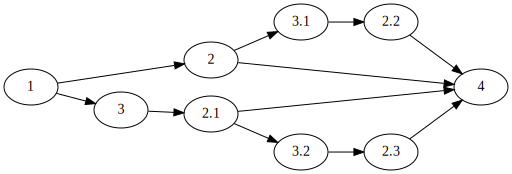

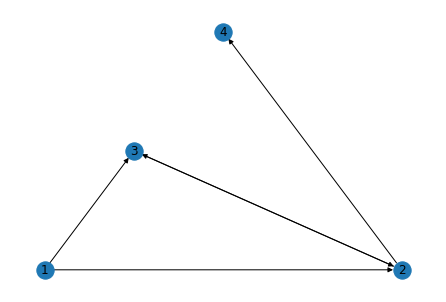

In [20]:
G=nx.DiGraph()
G.add_nodes_from(["1","2","3","4"])
G.add_edges_from([("1","2"),("1","3"),("2","3"),("3", "2"), ("2", "4")])
target = "4"

pos = nx.planar_layout(G)
nx.draw(G, with_labels = True, pos = pos)

k = 1
start = "1"

G_gen = unroll(G, start,[target],1)
A = to_agraph(G_gen)
A.layout('dot', args='-Grankdir=LR')
A.draw('gen.png')
A

In [21]:
# unrolling of user journey game
target = [s for s in g_before_colored.nodes if "positive" in s or "negative" in s]
g_before_unroll = unroll(g_before_colored, "start", target, 1)
target = [s for s in g_after_colored.nodes if "positive" in s or "negative" in s]
g_after_unroll = unroll(g_after_colored, "start", target, 1)

In [22]:
# assert that only one positive endpoint exists
def final_sound(g):
    # positive final states (should be one)
    positives = []
    for s in g.nodes:
        if "positive" in s:
            positives.append(s)
    assert(len(positives) == 1)
    
final_sound(g_before_unroll)
final_sound(g_after_unroll)

In [23]:
# construction of uppaal model (write model into upaal file)
def to_uppaal(g, name, layout = "sfdp", debug = False):
    f = open(UPPAAL_MODEL_FOLDER+name, "w+")
    
    pos = nx.drawing.nx_agraph.graphviz_layout(g, prog=layout, args='-Grankdir=LR')

    f.write('<?xml version="1.0" encoding="utf-8"?>')
    f.write("<!DOCTYPE nta PUBLIC '-//Uppaal Team//DTD Flat System 1.1//EN' 'http://www.it.uu.se/research/group/darts/uppaal/flat-1_1.dtd'>")
    f.write('<nta>')
    f.write('<declaration>')
    f.write('int e = 0;')
    f.write('\n'+'clock x;')
    f.write('\n'+'hybrid clock t;')
    f.write('\n'+'int steps;')
    f.write('\n'+'bool negative = false;')
    f.write('\n'+'bool positive = false;')
    f.write('\n'+'int final_gas = -1;')
    f.write('</declaration>')
    f.write('<template>')
    f.write('<name x="5" y="5">Template</name>')
    
    # print locations
    ids = {}
    branch = {}
    for s,i in zip(pos, range(len(pos))):
        ids[s] = i
        print_location(f, "id"+str(i),pos[s][0],pos[s][1],s)
        f.write('\n')
                    
    f.write('<init ref="id'+str(ids['start'])+'"/>')
    
    for e in g.edges:
        if "label" in g[e[0]][e[1]] and "controllable" in g[e[0]][e[1]]:
            if not g[e[0]][e[1]]["controllable"]:
                print_edge(f, ids[e[0]], ids[e[1]], pos[e[0]], pos[e[1]], g[e[0]][e[1]]['label'], g[e[0]][e[1]]['controllable'], e, g)
            else:
                print_edge(f, ids[e[0]], ids[e[1]], pos[e[0]], pos[e[1]], g[e[0]][e[1]]['label'], g[e[0]][e[1]]['controllable'], e, g)
        else:
            if "label" not in g[e[0]][e[1]]:
                if "controllable" not in g[e[0]][e[1]]:
                    print_edge(f, ids[e[0]], ids[e[1]], pos[e[0]], pos[e[1]], 0, True, e, g)

    f.write('</template>')
    f.write('<system>')
    f.write('Journey = Template();')
    f.write('system Journey;')
    f.write('</system>')
    f.write('</nta>')
    f.close()
    if debug:
        print("all written to", f.name)

def print_location(f, location_id, x, y, name):
    name = str(name)
    name = name.replace('"', '-')
    name = name.replace('{', '')
    name = name.replace('}', '')
    name = name.replace("'", '-')
    name = name.replace("_", '')
    name = name.replace("(", '')
    name = name.replace(")", '')
    f.write('<location id="'+location_id+'" x="'+str(int(x))+'" y="'+str(int(y))+'">')
    f.write('<name x="'+str(int(x))+'" y="'+str(int(y)+20)+'">'+str(name).replace(":", "").replace(" ","").replace(".", "").replace(",", "").replace("-","")+'</name>')
    f.write('<label kind="invariant" x="'+str(int(x))+'" y="'+str(int(y)-30)+'">')
    if "positive" not in name and "negative" not in name and "outOfGas" not in name:
        f.write('x &lt;= ' + str(2))
    else:
        f.write("t'==0")
    f.write('</label>')
    f.write('</location>')

def print_edge(f, s, t, pos_s, pos_t, w, controllable, e, g, guard = False):
    x = (pos_s[0]+pos_t[0])/2
    y = (pos_s[1]+pos_t[1])/2
    if controllable:
        f.write('<transition action = "">')
    else:
        f.write('<transition controllable="false" action = "">')
    f.write('<source ref="id'+str(s)+'"/>')
    f.write('<target ref="id'+str(t)+'"/>')
        
    f.write('<label kind="assignment" x="'+str(int(x))+'" y="'+str(int(y))+'">')
    f.write(' steps += 1')
    f.write(',\n'+ 'x = 0')
    if "positive" in str(e[1]):
        f.write(',\n'+ 'positive = true')
        f.write(',\n'+ 'final_gas = e +'+str(int(round(w))))
    elif "negative" in str(e[1]):
        f.write(',\n'+ 'negative = true')
        f.write(',\n'+ 'final_gas = e + '+str(int(round(w))))
        
    f.write(',\n'+'e = e + '+str(int(round(w))))
    f.write('</label>')
    
    f.write('</transition>')

if SAVE_ELEMENTS or True:
    to_uppaal(g_before_colored, "bpi2017_before.xml", layout = "dot")
    to_uppaal(g_before_unroll, "bpi2017_before_unroll.xml")

    to_uppaal(g_after_colored, "bpi2017_after.xml", layout = "dot")
    to_uppaal(g_after_unroll, "bpi2017_after_unroll.xml")

# Decision boundary computation
Function to create decision boundary plot, Fig. 4.
The decision boundary contains the states where the future outcome is decided.
There exists no chance to recover from the decision, the outcome is by then decided.

In [24]:
# Computes mapping R from alg. 1
def query(g):
    # partial graph implications, per activity
    results = {}
    
    for a in g.nodes:
        states = [a]

        sub_nodes = set()
        for s in states:
            sub_nodes.update(set(list(nx.descendants(g, s))))
            sub_nodes.add(s)
        if len(sub_nodes) > 80: # execute only on nodes with less than 80 descendants for better performance
            continue
        subgraph = nx.subgraph(g, sub_nodes)
        subgraph = nx.DiGraph(subgraph)

        # add start node to subgraph
        start_nodes = []
        for n in subgraph.nodes:
            if subgraph.in_degree(n) == 0:
                start_nodes.append(n)
        for n in start_nodes:
            subgraph.add_edge("start", n)
            subgraph["start"][n]["controllable"] = True
            subgraph["start"][n]["label"] = 0
        # if initial node lies on cycle, per default set as start node
        if "start" not in subgraph.nodes:
            for n in states:
                subgraph.add_edge("start", n)
                subgraph["start"][n]["controllable"] = True
                subgraph["start"][n]["label"] = 0

        target = [s for s in subgraph.nodes if "positive" in s or "negative" in s]
        subgraph_unrolled = unroll(subgraph, "start", target, 1)
        positives = []
        for s in subgraph_unrolled.nodes:
            if "positive" in s:
                positives.append(s)
        assert(len(positives) <= 1)
        to_uppaal(subgraph_unrolled, "bpi2017subgraph.xml")
        out = subprocess.Popen([VERIFYTA_PATH, UPPAAL_MODEL_FOLDER+INTERMEDIATE_MODEL_NAME, "guaranteed.q"], stdout=subprocess.PIPE)
        result = "is satisfied" in str(out.communicate()[0])
        results[a] = result
        
    return results

results_before = query(g_before_colored)
results_after = query(g_after_colored)

In [25]:
# mapping for event abbreviations - can be used as labels in the next cell
events_before = set([x['concept:name'] for trace in filtered_log_before for x in trace])
events_after = set([x['concept:name'] for trace in filtered_log_after for x in trace])
events = events_before.union(events_after)

events_abbreviation = {}
for e in events:
    numbers = [int(s) for s in e.split(" ") if s.isdigit()]
    if not numbers:
        events_abbreviation[e] = e[:3]
    else:
        assert(len(numbers)==1)
        events_abbreviation[e] = e[:3]+str(numbers[0])
    if "online only" in e:
        events_abbreviation[e] += ".o"
    if "mail and online" in e:
        events_abbreviation[e] += ".m+o"
    if "SHORT" in e:
        events_abbreviation[e] += ".s"
    if "SUPER LONG" in e:
        events_abbreviation[e] += ".sl"
    elif "LONG" in e:
        events_abbreviation[e] += ".s"

Nodes after the decision boundary are merged into "positive" and "negative" states.
1:1 connections in the graph are contracted.

In [26]:
# Computing nodes in decision boundary and generatig plot

# generate labels s.t. same nodes have same label in both plots
# new_labels shortens the node names and new_labels_int assigns integer codes
def compute_labels(g1, g2):
    new_labels = {}
    new_labels_int = {}
    
    both_nodes = []
    for n in g1.nodes:
        if n not in both_nodes:
            both_nodes.append(n)
    for n in g2.nodes:
        if n not in both_nodes:
            both_nodes.append(n)
    
    for n,i in zip(both_nodes, range(len(both_nodes))):
        h = [e.strip() for e in n.split("-")]
        h1 = events_abbreviation[h[0]]
        for e in h[1:]:
            h1 += " - "
            h1 += events_abbreviation[e]
        new_labels[n] = h1
        new_labels_int[n] = i

    new_labels.pop("start")
    
    new_labels_int.pop("start")
    return new_labels_int

# Updated draw_dfg function to produce Figure 5 (decision boundary reduction).
# Function improved readability in paper.
def draw_dfg(g, name, results, labels, layout = "sfdp"):
    g = copy.deepcopy(g)
    
    print("Decision boundary:")
    for s in results:
        pos = False
        neg = False
        if s not in g:
            # after contraction
            continue
        for n in g[s]:
            if "pos" in n:
                pos = True
            if "neg" in n:
                neg = True
        
        if pos and neg:
            g.nodes[s]['color'] = "blue"
            print(s,labels[s])
    
    # colour timeout edges
    for e in g.edges:
        if "TIMEOUT" in g[e[0]][e[1]]['action']:
            g[e[0]][e[1]]['color'] = "#9d4edd"

    
    edges = nx.bfs_edges(g, "start")
    nodes = ["start"] + [v for u, v in edges]   
    
    g = nx.relabel_nodes(g, labels)
    
    # merge start cluster together
    for n in nx.descendants_at_distance(g, "start", 2).union(nx.descendants_at_distance(g, "start", 1)):
        g = nx.contracted_nodes(g, "start", n)
        
    g.remove_edges_from(nx.selfloop_edges(g))
    
    for s in g:
        outgoing_sum = 0
        if "color" in g.nodes[s]:
            if g.nodes[s]['color'] == "blue":
                    continue
        for n in g[s]:
            if "label" in g[s][n]:
                outgoing_sum += g[s][n]["label"]
        if outgoing_sum >= 16:
            g.nodes[s]['color'] = "#0ead69"
        elif outgoing_sum <= -30:
            g.nodes[s]['color'] = "#9a031e"
        else:
            g.nodes[s]['color'] = "grey"

    A = to_agraph(g)
    edge_weights = nx.get_edge_attributes(g,'edge_weight')
    
    # process graph for readability in paper
    for e in g.edges:
        edge = A.get_edge(e[0], e[1])
        if 'controllable' in g[e[0]][e[1]]:
            if not g[e[0]][e[1]]['controllable']:
                edge.attr["style"] = "dotted"
        edge.attr["label"] = ""
    
    for n in A.nodes():
        n.attr['fontsize'] = 100
        n.attr['penwidth'] = 15
        n.attr['height'] = 2
        n.attr['width'] = 2
        if n == "pos":
            n.attr['color'] = "#0ead69"
            n.attr['fontcolor'] = "#0ead69"
        if n == "neg":
            n.attr['color'] = "#9a031e"
            n.attr['fontcolor'] = "#9a031e"
        if n not in ["pos", "neg"]:
            n.attr['label'] = ""
    for e in A.edges():
        e.attr['penwidth'] = 15
    
    A.graph_attr.update(size="7.75,10.25")
    A.write(name.split(".")[0]+".dot")
    A.layout(layout)
    print("Plotted", name)
    
    if SAVE_ELEMENTS:
        A.draw(name)
    return g
    
def reachable_cluster(g, results, name, labels):
    pos_cluster = []
    neg_cluster = []
    g = copy.deepcopy(g)
    to_remove = []
    for s in g:
        subgraph = nx.subgraph(g, set(list(nx.descendants(g, s))))
        subgraph = nx.DiGraph(subgraph)
        nodes = [s for s in subgraph]
        sub_results = [results[n] for n in results if n in nodes]
        if len(set(sub_results))<2:
            # sub_results has size 0 or 1: 0 if end node, 1 else
            if results[s]:
                pos_cluster.append(s)
            else:
                neg_cluster.append(s)

    for s in pos_cluster:
        g = nx.contracted_nodes(g, "pos", s)
    for s in neg_cluster:
        g = nx.contracted_nodes(g, "neg", s)
   
    g.remove_edges_from(nx.selfloop_edges(g))
    
    #g = merge_connections(g) # produces nicer plots but causes inaccuracies in analysis
    
    print("In edges to 'neg' ", len(g.in_edges("neg")))
    print("In edges to 'pos'", len(g.in_edges("pos")))
    print("Number of paths from start to 'pos' ", len(list(nx.all_simple_paths(g, "start", "pos"))))
    
    return draw_dfg(g, name, results, labels, layout = "dot")

    
def get_connection(g):
    for s in g:
        if len(list(g[s]))!= 1:
            continue
        assert(len(list(g[s]))==1)
        v = list(g[s])[0]

        edges = list(g.in_edges(v))
        if len(edges) == 1:
            s1 = edges[0][0]
            v1 = edges[0][1]
            assert(s == s1 and v == v1)
            return (s,v)
    return None

# Function to merge all 1:1 edges, produces a smaller plot
def merge_connections(g):
    g = copy.deepcopy(g)
    
    edge = get_connection(g)
    while(edge != None):
        g = nx.contracted_nodes(g, edge[0], edge[1])
        g.remove_edges_from(nx.selfloop_edges(g))
        edge = get_connection(g)
        
    return g

labels = compute_labels(g_before_colored, g_after_colored)
before_reachable = reachable_cluster(g_before_colored, results_before, 'clustered_before.png', labels)
after_reachable = reachable_cluster(g_after_colored, results_after,'clustered_after.png', labels)

In edges to 'neg'  26
In edges to 'pos' 9
Number of paths from start to 'pos'  568
Decision boundary:
W_Call after offers SHORT - A_Validating - O_Returned 9
A_Validating - O_Returned - W_Call incomplete files SHORT 10
A_Validating - O_Returned - W_Call incomplete files LONG 22
A_Accepted - O_Create Offer 0 - O_Sent (online only) 93
W_Call after offers SHORT - O_Create Offer 1 - O_Sent (online only) 133
Plotted clustered_before.png
In edges to 'neg'  32
In edges to 'pos' 11
Number of paths from start to 'pos'  234
Decision boundary:
W_Call after offers SHORT - A_Validating - O_Returned 9
A_Validating - O_Returned - W_Call incomplete files SHORT 10
A_Validating - O_Returned - W_Call incomplete files LONG 22
W_Call after offers SUPER LONG - A_Validating - O_Returned 87
W_Call after offers SHORT - O_Create Offer 1 - O_Sent (online only) 133
O_Sent (mail and online) - O_Create Offer 1 - O_Sent (online only) 139
W_Call incomplete files SHORT - O_Returned - W_Call incomplete files SHORT 159


In [27]:
# computes the after length of paths until timeout event
def pos_distance(g):
    count = 0
    length_sum = 0
    for n in g:
        if "neg" in g[n] and "TIMEOUT" in g[n]["neg"]['action']:
            length = nx.shortest_path_length(g, "start", n)
            length_sum += length
            count += 1
    print("average length until timeout", length_sum/count)
# needs to be executed on model without merged 1:1 edges for realistic results
pos_distance(before_reachable)
pos_distance(after_reachable)

average length until timeout 5.4375
average length until timeout 5.0


In [28]:
# Set of nodes reaching the decision boundary

count = set()
for s in before_reachable:
    if "color" in before_reachable.nodes[s]:
        if before_reachable.nodes[s]['color'] == "blue":
            count = count.union(set([x[0] for x in list(before_reachable.in_edges(s))]))
to_remove = []
for e in count:
    if "color" in before_reachable.nodes[e]:
        if before_reachable.nodes[e]['color'] == "blue":
            to_remove.append(e)
for e in to_remove:
    count.remove(e)
    
print("Before the concept drift reach ", sorted(list(count)), "(", len(count),")", "the decision boundary")

count = set()
for s in after_reachable:
    if "color" in after_reachable.nodes[s]:
        if after_reachable.nodes[s]['color'] == "blue":
            count = count.union(set([x[0] for x in list(after_reachable.in_edges(s))]))

to_remove = []
for e in count:
    if "color" in after_reachable.nodes[e]:
        if after_reachable.nodes[e]['color'] == "blue":
            to_remove.append(e)
for e in to_remove:
    count.remove(e)
print("After the concept drift reach ", sorted(list(count)), "(", len(count),")", "the decision boundary")

Before the concept drift reach  [5, 8, 16, 19, 37, 87] ( 6 ) the decision boundary
After the concept drift reach  [8, 16, 19, 37, 41, 86, 158, 169] ( 8 ) the decision boundary


# UPPAAL Plot
In the following are the UPPAAL simulations visualised.
On the first event log (including events until July 2016) are strategies to maximize the final gas, minimize the expected number of steps and a combination of both simulated.

In [29]:
def read_csv(path):
    simulations = []
    lines = []
    with open(path) as file:
        lines = file.readlines()
        lines = [line.rstrip() for line in lines]
    lines = [line for line in lines if "##" not in line]
    lines.pop(0)
    x = []
    y = []
    current_x = []
    current_y = []
    current_simulation = []
    for line in lines:
        if "#" in line:
            current_x.append(30)
            current_y.append(current_y[-1])
            x.append(current_x)
            y.append(current_y)
            current_x = []
            current_y = []
        else:
            current_x.append(float(line.split(",")[0]))
            current_y.append(float(line.split(",")[1]))
    return x,y

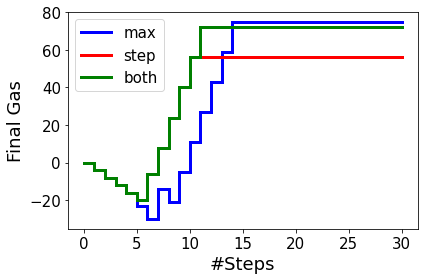

In [30]:
x_max,y_max = read_csv("max.csv")
x_step, y_step = read_csv("step.csv")
x_both, y_both = read_csv("both.csv")
plt.rcParams["figure.autolayout"] = True
for x, y, label, c in [(x_max, y_max, "max", "b"), (x_step, y_step, "step", "r"), (x_both, y_both, "both", "g")]:
    for i in range(len(x)):
        if i == len(x)-1:
            plt.plot(x[i],y[i], c = c, linewidth = 3, label = label)
        else:
            plt.plot(x[i],y[i], c = c, linewidth = 3)
#plt.yticks(np.arange(min(x), max(x)+1, 1.0))
plt.legend(fontsize = 15)
plt.savefig("simulation.png")
plt.xlabel("#Steps",  fontsize=18)
plt.ylabel("Final Gas",  fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()